# Unit 6: Linear Regression & Gradient Descent
`Live Session 6 Code Demo`  
`w261 - Machine Learning at Scale 
UC Berkeley, MIDS`

<a id=TOC></a>
## CONTENTS
* [Introduction](#intro)
* [A Small Example](#small_ex): _for illustrating the math_.
* [Demo # 1](#demo1): A haphazard approach to learning weights.
* [Demo # 2](#demo2): Systematic (Brute Force) search for parameters.
* [Theory Interlude 1](#TL1): **Convexity & The Gradient.** 
* [Demo # 3](#demo3): Closed Form Solution for OLS Regression.
* [Theory Interlude 2](#TL2): **Model Space vs. Parameter Space**
* [Demo # 4](#demo4): Gradient Descent
* [Demo # 5](#demo5): Numerical Approximation.
* [Theory Interlude 3](#TL3): **GD Parallelization Considerations**
* [Demo # 6](#demo6): Stoichastic vs Batch GD.
* [A Bigger Example](#big_ex): _and some real world considerations._
* [Demo # 7](#demo7): The Importance of Normalization.
* [Theory Interlude 4](#TL4): **Regularization**
* [Demo # 8](#demo8): Lasso vs. Ridge
* [APPENDIX A](#AppendixA): **Math Notes**
* [APPENDIX B](#AppendixB): **Supporting Code**

<a id=intro></a>
# Introduction
[Return to Contents](#TOC) | [Skip to Appendix](#AppendixA)

In today's demo, we'll use Linear Regression as a simple example in order to explore key topics related to distributed learning of parametric models. Broadly speaking, the supervised learning of a parametric model can be split into to two components:
1. **Prediction Task**: Given an input vector, return an output value.
2. **Optimization Task (a.k.a. Learning)**: Given a strategy for making a prediction, return the specific parameters which guarantee the optimal prediction.

> __DISCUSSION QUESTION:__ _In the case of Linear Regression, which of the two tasks above are we most likely to want to parallelize? Why?_


OK, Let's start with a quick review of some notation you will have seen in w207. 

## Notation Review

Linear Regression tackles the __prediction task__ by assuming that we can compute our output variable, $y$, using a linear combination of our input variables.  That is, when performing Linear Regression we assume that there exist **weights**, $w_i$, such that at each point $x_1, ... x_N \in X \subset \mathbb{R}^m$

\begin{equation}\tag{1.1}
y_j = \displaystyle\sum_{i=0}^{m}{w_i*x_{ji}} \quad \{j = 1 \dots N\}
\end{equation}

Of course, this perfect linear relationship never holds over a whole dataset **$X$**, so Linear Regression attempts to fit (i.e. **learn**) the best line (in 1 dimension) or hyperplane (in 2 or more dimensions) to the data.  In the case of **ordinary least squares (OLS)** linear regression, best fit is defined as minimizing the Euclidean distances of each point in the dataset to the line or hyperplane.  These distances are often referred to as **residuals**. The calculation of the average residual (a.k.a.**mean squared error, MSE**) over our test or training set allows us to measure how good a fit we've achieved:

\begin{equation}\tag{1.2}
J(W, X) = \frac{1}{2N}\displaystyle\sum_{j=1}^{N}\left(y_j - \displaystyle\sum_{i=1}^{m}{w_i*x_{ji}}\right)^2
\end{equation}

In matrix notation, this can be written:

\begin{equation}\tag{1.3}
J(W, X) = \frac{1}{2N}\displaystyle\sum_{j=1}^{N}\left(y_j - W^TX_j\right)^2
\end{equation}

We call this function the **loss** or **objective** function because our goal in the **optimization task** is to find the parameters which minimize it. However, it is important to note that the loss function depends on both the parameters $W$ _and_ the data $X$, we'll talk more about that later.

> __DISCUSSION QUESTION:__ _In equation 1.1 what are $x_{ji}$, $m$, and $N$? In the asynch's version of the loss function $\alpha$ and $\beta$ appear as parameters... what do they represent? How are they captured in equation 1.2? What is different about the presentation here?_

## Code Prep

In [55]:
# general imports
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import sklearn

# magic commands
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Before we begin, please run the cells in [Appendix B](#AppendixB) to generate the supporting files & helper code that we'll use in our demos. When you're done, return here to get started.

<a id=small_ex></a>
# A Small Example
[Return to Contents](#TOC) | [Jump to Demo 1](#demo1) | [Skip to Appendix](#AppendixA)

We'll start with a small example of 5 2-D points:

In [107]:
%%writefile fivePoints.csv
1,2
3,4
5,5
4,3
2,3

Overwriting fivePoints.csv


Here's what they look like next to a hypothetical linear model:  $ y = 1*x + 2$

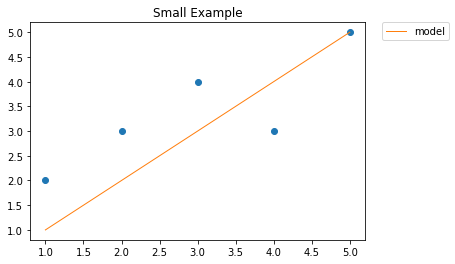

In [176]:
# easy plotting with a helper function
from helperFunc import plot2DModels
points = np.genfromtxt("fivePoints.csv", delimiter=',')
plot2DModels(points, [('model',[0,1])],title = 'Small Example')

Looks reasonable, but its hard to gauge exactly how good a fit we have just by looking.

> __A TASK FOR YOU:__ Fill in the calculations below to compute the "Training Loss" for our data. These are easy and intuitive calculations that you will know from long-ago math classes... but instead of relying on your visual intuition, challenge yourself to think through these numbers in the context of our matrix equation for loss. Here it is again for your reference:
\begin{equation}\tag{1.3}
J(W, X) = \frac{1}{2N}\displaystyle\sum_{j=1}^{N}\left(y_j - W^TX_j\right)^2
\end{equation}


The weight vector $W$ for our line is: 
$ \begin{bmatrix} ? \\ ? \\ \end{bmatrix}$
         
The (augmented) data points $x_j$ are:
$ \begin{bmatrix} ? \\ ? \\ \end{bmatrix}$
$ \begin{bmatrix} ? \\ ? \\ \end{bmatrix}$
$ \begin{bmatrix} ? \\ ? \\ \end{bmatrix}$
$ \begin{bmatrix} ? \\ ? \\ \end{bmatrix}$
$ \begin{bmatrix} ? \\ ? \\ \end{bmatrix}$

Our loss calculations will be:

|$j$  | $y_j$ |   $W^T\cdot X_j$ | $(y_j - W^T X_j)^2$ |
|:---:|:-----:|:----------------:|:------------------------:|
|     | output value   |   matrix product   |  squared residual       |
| 1   |       |                  |             |
| 2   |       |                  |    |
| 3   |       |                  |    |
| 4   |       |                  |    |
| 5   |       |                  |    |

 The training loss $J(W,X)$ for this data and these weights is: _______
 

In [177]:
# confirm your hand calculation by running this cell
from helperFunc import augment
from linRegFunc import OLSLoss
X = augment(points)[:,:-1]
y = points[:,-1]
print "Loss:", OLSLoss(X, y,[0,1])

Loss: 0.4


In [138]:
y - W.dot(X.T)

array([ 1.,  1.,  0., -1.,  1.])

 > __DISCUSSION QUESTION:__ What parts of this computation could be parallelized? What, if any, aggregation has to happen at the end? What key-value format, partitioning, sorting would help? Could you use a combiner? In addition to the data stream, what other information would your map or reduce tasks need access to? 

<a id=demo1></a>
# Demo 1: A haphazard approach to learning.
[Return to Contents](#TOC) | [Skip to Appendix](#AppendixA)

Ok, so we know the model looks ok and we know its loss is $0.4$ but is that any good? A naive approach to "learning" a Linear Model might be to randomly generate a few more models and then pick the model with the lowest loss. Let's try it.

Best Random Model: [-3.80237981  2.96104282], Loss: 7.14698120855


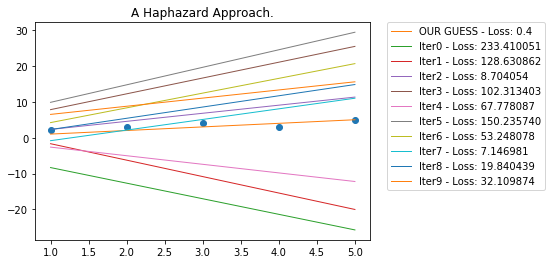

In [180]:
from helperFunc import plot2DModels
from linRegFunc import OLSLoss

# set a number of models to try
NUM_ITER = 10

# load & pre-process data
points = np.genfromtxt("fivePoints.csv", delimiter=',')
X = augment(points)[:,:2]
y = points[:,1]

# "training"
models = [("OUR GUESS - Loss: 0.4",[0,1])]
best = {'loss':100, 'W': None}
for idx in range(NUM_ITER):
    # initialize a random weight vector
    W = np.random.uniform(-5,5, size=(2))
    loss = OLSLoss(X, y, W)
    models.append(("Iter%s - Loss: %2f" % (idx, loss), W))
    # track best model
    if loss < best['loss']:
        best['loss'] = loss
        best['W'] = W
        
# results
print "Best Random Model: %s, Loss: %s" % (best["W"], best["loss"])
plot2DModels(points, models, "A Haphazard Approach.")

So, that was pretty poor. One idea would be to run a lot more iterations.

> __DISCUSSION QUESTION:__ To what extent could parallelization help us redeem this approach? What exactly would you parallelize?

<a id=demo2></a>
# Demo 2: Systematic Brute Force.
[Return to Contents](#TOC) | [Skip to Appendix](#AppendixA)

For obvious reasons a more systematic approach is desirable. Instead of randomly guessing, lets use what we know to search an appropriate section of the the model space.

We can tell from the data that the linear model should probably have a fairly shallow positive slope and a positive intercept between 0 and 2. So lets initialize every possible combination of weights in that range up to a granularity of, say $0.2$, and compute the loss for each one.

Best model: [ 1.6  0.6], Loss: 0.16


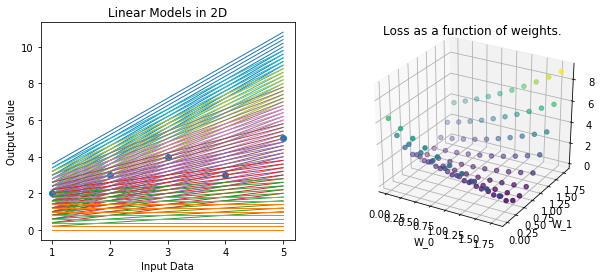

In [271]:
from helperFunc import plot3DLoss
from linRegFunc import OLSLoss

### Load & Pre-process Data
points = np.genfromtxt("fivePoints.csv", delimiter=',')
X = augment(points)[:,:2]
y = points[:,1]

### "Training"
# simulate grid coordinates to act as our models
grid = np.mgrid[0:2:0.2,0:2:0.2].reshape(2,100).T

# compute loss
loss = []
for W in grid:
    loss.append(OLSLoss(X,y,W))
    
# take a look at the results
print "Best model: %s, Loss: %s" % (grid[np.argmin(loss)], min(loss))
plot3DLoss(points,grid,loss)

> __DISCUSSION QUESTION:__ When we think about scaling up, is this still a better approach than guessing? How could it be parallelized? What if we had higher dimension data?

<a id=TL1></a>
# Theory Interlude: Convexity & the Gradient 
[Return to Contents](#TOC) | [Skip to Appendix](#AppendixA)

Instead of messing around with guesses, why not apply some theory to this task? Calculus gives us the simple solution to optimizing a real function, i.e. finding $x^*$, if the function is [differentiable](https://en.wikipedia.org/wiki/Differentiable_function).  We take the first derivatives (also called the gradients) of the function, set them equal to zero, and solve for $x^*$.  These equations, derivatives = 0, are called the **first order conditions.**  

Recall the matrix formulation of our loss function:

\begin{equation}\tag{1.3}
J(W, X) = \frac{1}{2N}\displaystyle\sum_{j=1}^{N}\left(y_j - W^TX_j\right)^2
\end{equation}

By taking the first partial derivatives and setting them all equal to 0, we get the following matrix **"closed form"** solution to the OLS linear regression optimization problem

\begin{equation}\tag{2.1}
\hat{w} = \left(X^TX\right)^{-1}X^Ty
\end{equation}

If $X^TX$ is denoted by $A$, and $X^Ty$ is denoted by $b$, then

\begin{equation}\tag{2.2}
\hat{w} = A^{-1}b
\end{equation}

Equivalently, we can solve the following linear matrix equation for $\hat{w}$:

\begin{equation}\tag{2.3}
A\hat{w} = b
\end{equation}


When the first derivatives are equal to zero, then we know we are at a local maximum or minimum of the real function.  But which one is it?  In order to tell, we must take the second derivatives of the real function.  If the second derivatives are positive at $x^*$, then we know we are at a minimum.  If the second derivatives are negative, then we know we are at a maximum.  These are the **second order conditions.**

<img src="https://dl.dropbox.com/s/j5n5kvbeghrxj8o/faces.png" width="500" height="500" />

__Convex Optimization__ is the lucky case where we know that the second derivatives never change sign. There are lots of complicated loss functions for which we can't easily visualize the error surface but for which we _can_ prove mathematically that this 2nd order condition is ment. If this is the case, then we can think of the suface as _always curving up_ or _always curving down_ which guarantees that any minimum we reach will be an absolute minimum. 

> __Discussion Question:__ If we are searching the parameter space for a lowest point, why might it be useful to know that our loss function is convex? 

<a id=demo3></a>
# Demo 3: Closed Form Solution
[Return to Contents](#TOC) | [Skip to Appendix](#AppendixA)

<a id=TL2></a>
# Theory Interlude: Model Space vs. Parameter Space
[Return to Contents](#TOC) | [Skip to Appendix](#AppendixA)

<a id=demo4></a>
# Demo 4: Gradient Descent
[Return to Contents](#TOC) | [Skip to Appendix](#AppendixA)

<a id=demo5></a>
# Demo 5: Numerical Approximation
[Return to Contents](#TOC) | [Skip to Appendix](#AppendixA)

<a id=TL3></a>
# Theory Interlude: GD Parallelization Considerations
[Return to Contents](#TOC) | [Skip to Appendix](#AppendixA)

<a id=demo6></a>
# Demo 6: Stoichastic vs Batch GD
[Return to Contents](#TOC) | [Skip to Appendix](#AppendixA)

<a id=big_ex></a>
# A Bigger Example: Boston House Prices Dataset
[Return to Contents](#TOC) | [Skip to Appendix](#AppendixA)

Ok, now that we have a handle on the math and the basic design choices involved in implementing & parallelizing Gradient Descent. Lets look at a slightly bigger example: the boston housing prices dataset. We'll use Sklearn to build a Linear Regression Model for this data.

In [272]:
# ML modules
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

/opt/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [273]:
# we'll also fix the random see for reproducibility
np.random.seed(42)

### Reading in the Data

In [276]:
# load the data & take a look
from sklearn.datasets import load_boston
boston = load_boston()

In [275]:
# optional - view description
print(boston.DESCR)

In [282]:
# create data frame & test/train split
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [278]:
# take a look
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


### A little EDA

In [283]:
# summary statistics
X.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


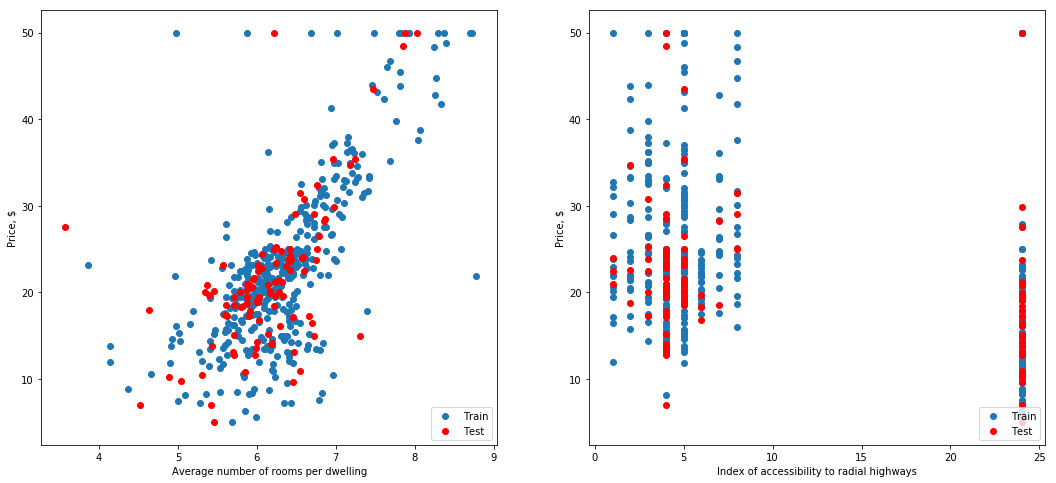

In [284]:
# these data have a lot of features, lets visualize two of them:
plt.figure(figsize=(18, 8))
plt.subplot(121)
plt.scatter(X_train.RM, y_train, label="Train")
plt.scatter(X_test.RM, y_test, c="r", label="Test")
plt.xlabel("Average number of rooms per dwelling")
plt.ylabel("Price, $")
plt.legend(loc="lower right", frameon=True)
plt.subplot(122)
plt.scatter(X_train.RAD, y_train, label="Train")
plt.scatter(X_test.RAD, y_test, c="r", label="Test")
plt.xlabel("Index of accessibility to radial highways")
plt.ylabel("Price, $")
plt.legend(loc="lower right")
plt.show()

> __DISCUSSION QUESTION:__ What will happen in the Gradient Descent update step when you have input variables that are measured on very different scales? What other design choices affect this risk?

<a id=demo7></a>
# Demo 7: Normalizing the data
[Return to Contents](#TOC) | [Skip to Appendix](#AppendixA)

----- NEED TO INSERT DISCUSSION OF SCALING HERE... maybe even add an illustrative example of how things go wrong?----

So, let's also do normalization to the range of  (0;1) to make our data insensitive to the scale of features:

In [285]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

__Now that we have normalized data, lets run a simple regression__

In [286]:
# initialize the model
model_sk = LinearRegression()

# fit the data
model_sk.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

__Evaluation__

Let's see what features are significant for the model

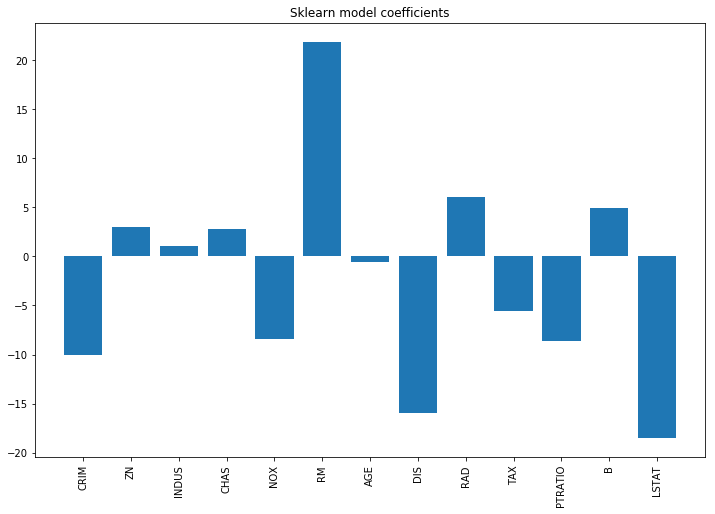

In [287]:
plt.figure(figsize=(12, 8))
plt.bar(np.arange(model_sk.coef_.shape[0]), model_sk.coef_)
plt.xticks(np.arange(model_sk.coef_.shape[0]), X.columns, rotation='vertical')
plt.xlim([-1, model_sk.coef_.shape[0]])
plt.title("Sklearn model coefficients")
plt.show()

__ RMSE Evaluation?__

<a id=TL4></a>
# Theory Interlude: Regularization
[Return to Contents](#TOC) | [Skip to Appendix](#AppendixA)

<a id=demo8></a>
# Demo 8: Lasso vs Ridge
[Return to Contents](#TOC) | [Skip to Appendix](#AppendixA)

<a id=AppendixA></a>
# Appendix A: Math Notes
[Return to Contents](#TOC) | [Skip to Appendix](#AppendixA)

<a id=AppendixB></a>
# Appendix B: Supporting Code.
[Return to Contents](#contents) | [Return to the first example](#small_ex) 

This section of the notebook contains the code for the supporting files referenced throughout this notebook. These include:  
* `helperFunc.py` - _functions to create, plot, and transform data_
* `linRegFunc.py` - _functions to run Linear Regression via gradient descent._  

__WARNING: running the cells below will recreate each file and overwrite any existing file of the same name.__

### `helperFunc.py`

In [270]:
%%writefile helperFunc.py
#!/opt/anaconda/bin/python2.7
"""
This file contains helper functions for generating, transforming
and plotting 2 dimensional data to use in testing & for ML demos.

Avaliable functions include:
    augment(X)
    plot2DModels(data, model_dict=None, title=None)

"""
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def augment(X):
    """
    Takes an np.array whose rows are data points and augments each
    each row with a 1 in the 0th position to represent the bias.
    """
    return np.insert(X, 0, 1.0, axis=1)


def plot2DModels(data, model_list=[], title=None):
    """
    Plot a set of 2d models for comparison.
    INPUT:  data       - numpy array of points x, y
            model_list - [(label,[w_0, w_1]), ...]
            title      - (optional) figure title
    """
    # create plot
    fig, ax = plt.subplots()
    # plot data
    ax.plot(data[:,0], data[:,1],'o')
    domain = [min(data[:,0]), max(data[:,0])]
    # plot models
    for label, W in model_list:
        m , b = W[1], W[0]
        yvals = [m*x + b for x in domain]
        ax.plot(domain, yvals, linewidth=1, label=label)
    if model_list:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    # title & formatting
    if title:
        plt.title(title)
        
def plot3DLoss(data, weight_grid, loss, title=None):
    """
    Plot a set of 2d models for comparison.
    INPUT:  data    - numpy array of points x, y
            models  - numpy array of weight vectors [w_0, w_1]
            loss    - list/array of loss corresponding to ^
            title   - (optional) figure title
    """
    # create figure
    fig = plt.figure(figsize=plt.figaspect(0.4))

    # plot data
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(data[:,0], data[:,1],'o')
    ax1.set_title("Linear Models in 2D")
    plt.xlabel('Input Data')
    plt.ylabel('Output Value')
    domain = [min(data[:,0]), max(data[:,0])]
    
    # plot models
    for W in weight_grid:
        m , b = W[1], W[0]
        yvals = [m*x + b for x in domain]
        ax1.plot(domain, yvals, linewidth=1)

    # plot loss in 3D
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.set_title("Loss as a function of weights.")
    plt.xlabel('W_0')
    plt.ylabel('W_1')
    X,Y = weight_grid.T
    ax2.scatter(X,Y,loss, c=loss)
    
    
    # title & formatting
    if title:
        plt.title(title)

Overwriting helperFunc.py


### `linRegFunc.py`

In [139]:
%%writefile linRegFunc.py
#!/opt/anaconda/bin/python2.7
"""
This file contains several functions for OLS Linear Regression.

Avaliable functions include:
    OLSloss(X, y, model)
"""
import numpy as np

def OLSLoss(X, y, model):
    """
    Computes mean squared error for a linear model.
    INPUT:  X - numpy array with each row representing an input point
            y - numpy array of true outputs
            model  - [w_0, w_1] (bias & coefficient)
    """
    N = len(X)
    W = np.array(model)
    return 1/(2.0*N) * sum((y - W.dot(X.T))**2)
    

Overwriting linRegFunc.py


`CREATED BY: Maya Miller-Vedam, Oct 2017 for w261 Machine Learning at Scale, UC Berekeley MIDS -- many thanks to Dr. James Shanahan and Marguerite Oneto from whom I have liberally drawn code & explanations.`